## Sweep over k1 

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl; 
fs=17
font = {'family' : 'DejaVu Sans',  'size'   : fs}
mpl.rc('font', **font)

In [2]:
# task: post-processing - adjust to make the cell degrade to a reasonable value
variables = [
    "Discharge capacity [A.h]",
    #"Positive electrode capacity [A.h]",
    #"Negative electrode capacity [A.h]",
    "Loss of capacity to negative SEI [A.h]",
    "Total lithium capacity in particles [A.h]",
    #"Loss of capacity to negative SEI on cracks [A.h]",
    # "Loss of capacity to lithium plating [A.h]",
    # "X-averaged positive particle moving phase boundary location",
    "X-averaged loss of active material due to PE phase transition",
    "X-averaged positive electrode shell layer overpotential [V]",
    "Positive electrode stoichiometry",
    "Negative electrode stoichiometry",
]
Short_ylabel ={
    "Discharge capacity [A.h]": "Cap / A.h" ,
    "Loss of capacity to negative SEI [A.h]": "LLI to SEI / A.h",
    "Total lithium capacity in particles [A.h]": "Li in Particle / A.h" ,

    "X-averaged loss of active material due to PE phase transition": "LAM PE to Phase change / A.h" ,
    "X-averaged positive electrode shell layer overpotential [V]": "eta PE shell / V",
    "Positive electrode stoichiometry Start": "PE Sto Start" ,
    "Negative electrode stoichiometry Start": "NE Sto Start" ,
    "Positive electrode stoichiometry End": "PE Sto End" ,
    "Negative electrode stoichiometry End": "NE Sto End" ,
}

def Run_Model_with_param(param,variables,step_DC, total_cycles, save_at_cycles):
    
    model = pybamm.lithium_ion.SPM({
        "SEI": "interstitial-diffusion limited",
        "PE degradation": "phase transition",
        })
    experiment = pybamm.Experiment(
        [
            (        
                "Charge at 0.3C until 4.2 V",
                "Hold at 4.2 V until C/50",
                "Rest for 30 minutes",
                "Discharge at 0.3C until 2.8 V",
                "Rest for 60 minutes",
            )
        ] * total_cycles,
        # period="0.5 minute",
    )
    sim = pybamm.Simulation(
        model, experiment=experiment, 
        parameter_values=param,
        # solver=pybamm.CasadiSolver("fast with events"),
    )
    solution = sim.solve(
        calc_esoh=False, 
        save_at_cycles = save_at_cycles)
    Sol_dict = {}

    cycle_numbers = np.arange(0, total_cycles+save_at_cycles, save_at_cycles)
    cycle_numbers = cycle_numbers-1
    cycle_numbers[0] = 0

    Sol_dict["Cyc No."] = cycle_numbers
    for var in variables:
        
        if var in ["Discharge capacity [A.h]"]:
            Sol_dict[var] = []
            for i in cycle_numbers:
                Q_dis_cyc = solution.cycles[i].steps[3]["Discharge capacity [A.h]"].entries
                Q_dis = abs(Q_dis_cyc[-1] - Q_dis_cyc[0])
                Sol_dict[var].append(Q_dis)
        elif var in ["Positive electrode stoichiometry","Negative electrode stoichiometry"]:
            Sol_dict[var + " Start"] = []
            Sol_dict[var + " End"] = []
            for i in cycle_numbers:
                Sol_dict[var + " Start"].append(
                    solution.cycles[i].steps[step_DC][var].entries[0])
                Sol_dict[var + " End"].append(
                    solution.cycles[i].steps[step_DC][var].entries[-1])
        else:
            Sol_dict[var] = []
            for i in cycle_numbers:
                Sol_dict[var].append(
                    solution.cycles[i][var].entries[0]
                )
    return Sol_dict


In [3]:
# "Forward chemical reaction coefficient [m.s-1]" k1 -  0.8544e-11,
# "Reverse chemical reaction coefficient [m4.mol-1.s-1]" k2  -  1.732e-16,
# "Positive shell oxygen diffusivity [m2.s-1]" Do   - 1e-17


param = pybamm.ParameterValues("Zhuo2023") 
k1_list = [ 1e-13, 7e-14, 4e-14, 1e-14]
Sol_Dict_List = []
for k1 in k1_list:
    param["Forward chemical reaction coefficient [m.s-1]"] = k1
    Sol_Dict_List .append( 
        Run_Model_with_param(
            param, variables, step_DC = 3, 
            total_cycles = 1000, save_at_cycles = 50))

In [7]:
import matplotlib as mpl; 
fs=17
font = {'family' : 'DejaVu Sans',  'size'   : fs}
mpl.rc('font', **font)


import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
Save_fig_path = str_path_0 + "/examples/Reproduce_Pe_degrade_paper"

In [5]:
cap_list = Sol_Dict_List[0]["Discharge capacity [A.h]"]
soh_list = cap_list / cap_list[0]
soh_list

array([1.        , 0.99551052, 0.99098629, 0.98653622, 0.98213667,
       0.9777569 , 0.97330594, 0.96868541, 0.96350846, 0.95447103,
       0.94021553, 0.92549986, 0.91082636, 0.8962234 , 0.88171984,
       0.86733492, 0.85307028, 0.83895547, 0.8249839 , 0.81116576,
       0.79751368])

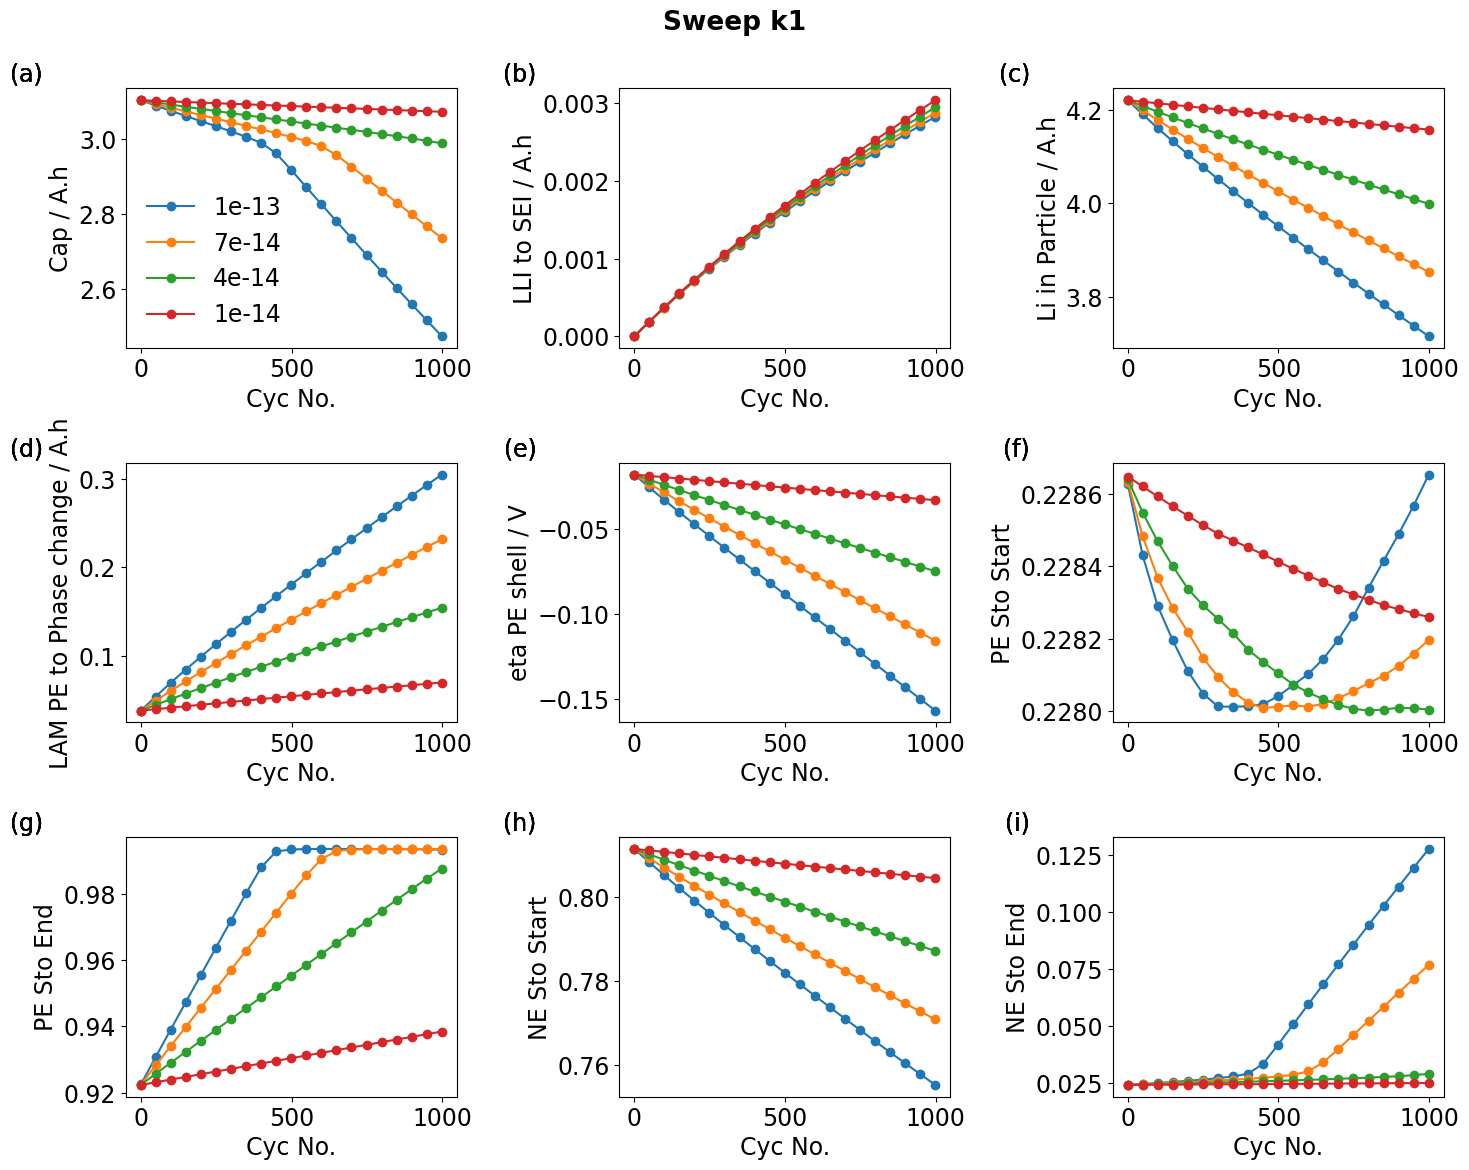

In [8]:
def Plot_Summary(Sol_dict, axs, label, subplot_labels):
    variables = Sol_dict.keys()
    i = 0
    for var in variables:
        if var in ["Cyc No."]:
            pass
        else:
            axs[i].plot(Sol_dict["Cyc No."],Sol_dict[var],"-o", label = label)
            axs[i].set_ylabel(Short_ylabel[var])
            axs[i].set_xlabel("Cyc No.")
            axs[i].text(
                -0.25, 1.1, 
                subplot_labels[i], transform=axs[i].transAxes, 
                fontsize=fs,  # fontweight='bold', 
                va='top', ha='right')
            i += 1
    return axs

subplot_labels = [
    "(a)", "(b)", "(c)", 
    "(d)", "(e)", "(f)", 
    "(g)", "(h)", "(i)", ]
fig, Axs = plt.subplots(3,3, figsize=(15,12),tight_layout=True)
axs = Axs.flatten()
for k1, Sol_dict in zip(k1_list, Sol_Dict_List):
    axs = Plot_Summary(Sol_dict, axs, label=k1, subplot_labels=subplot_labels)
fig.suptitle(
    "Sweep k1",  fontsize=fs+2, fontweight='bold', )
axs[0].legend(loc='best',frameon=False)


fig.savefig(Save_fig_path + "/Sweep k1.svg")
